In [55]:
import sys
#sys.path.insert(0, '/tigress/jk11/slug_cluster/python/')
#sys.path.insert(0, '/tigress/jk11/athena-tigress/python/')
sys.path.insert(0, os.path.join(os.path.expanduser('~'),
                                'Dropbox/code/tigress_cooling/python'))
sys.path.insert(0, os.path.join(os.path.expanduser('~'),
                                'Dropbox/code/slug_cluster/python'))

import cool_tigress as ct
from slug_cluster import slug_cluster
from scipy import integrate

In [172]:
class IntegrateSED(object):
    """Class for integrating slug SED and 
    computing mean photoionization cross section and mean ionizing photon energy
    """
    
    integrators = {'trapz': integrate.trapz,
                   'simps': integrate.simps}
    hc = (1.0*(ac.h*ac.c).cgs).value
    Angs = (1.0*au.Angstrom).cgs.value
    eV = (1.0*au.eV).cgs.value
    Lsun = ac.L_sun.cgs.value
    
    def __init__(self, sed_kind='slug', integrator_method='simps'):
        
        self.integrator = IntegrateSED.integrators[integrator_method]
        self.ea = ct.EnumAtom
        self.ph = ct.Photx()
        self.set_species()
        
        # Slug SED
        if sed_kind == 'slug':
            self.sc = slug_cluster(output_dir='../../code/slug_cluster_data')
            self.sed_all = self.sc.get_sed_med_avg()
            self.time = self.sed_all['time']/1e6
            self.wl = self.sed_all['wl']
            self.wl_lim = {'H0': (0.0, 912.11),     # Lyman
                           'FUV': (912.11, 2066.0), # 6.0eV - 13.6
                           'LW': (912.11, 1108.0)   # LW band (~ 11.3 - 13.6 eV) Sternberg+14
                           }

    
    def set_species(self):
        # Set Z (nuclear charge) and N (number of electron) for each ionic species
        self.ion_species = dict(HI=(1, 1), 
                                HeI=(2, 2),
                                CI=(6, 6),
                                OI=(8, 8),
                                OII=(8, 7),
                               )

    def integrate_sed(self, logM=5.0, 
                      teval=np.array([0.1, 3, 5, 10, 40]), kind='med'):
        
        if teval is None:
            teval = self.time
            
        self.sed = self.get_sed(logM=logM, teval=teval, kind=kind)

        
        L = dict()
        Q = dict()
        hnu = dict()
        sigma_ph = dict()
        dhnu = dict()
        for spc in self.ion_species.keys():
            sigma_ph[spc] = dict()
            dhnu[spc] = dict()
        
        Lbol = np.zeros((len(teval),))
        for k in self.wl_lim.keys():
            L[k] = np.zeros((len(teval),))
            Q[k] = np.zeros((len(teval),))
            hnu[k] = np.zeros((len(teval),))
            for spc in self.ion_species.keys():
                sigma_ph[spc][k] = np.zeros((len(teval),))
                dhnu[spc][k] = np.zeros((len(teval),))

        for i in range(self.sed.shape[0]):
            Lbol[i] = self.get_lum_bol(self.sed[i, :], self.wl)
            
            for k, wl_lim in self.wl_lim.items():
                lum_, Q_, hnu_ = self.get_lum_Q_hnu(self.sed[i, :], self.wl, wl_lim)
                L[k][i] = lum_
                Q[k][i] = Q_
                hnu[k][i] = hnu_
                for spc, ZN in self.ion_species.items():
                    # Number of nuclear charge
                    Z = ZN[0]
                    ## Number of electrons
                    N = ZN[1]
                    res = self.get_sigmaph_dhnu(self.ph, self.sed[i, :], 
                                                self.wl, wl_lim, Z, N, verbose=False)

                    sigma_ph[spc][k][i] = res['sigma_ph']
                    dhnu[spc][k][i] = res['dhnu']

        self.teval = teval
        self.Lbol = Lbol
        self.L = L
        self.Q = Q
        self.hnu = hnu
        self.sigma_ph = sigma_ph
        self.dhnu = dhnu
        
    def get_sed(self, logM=5.0,
                teval=np.array([0.1, 3, 5, 10, 40]), kind='med'):
        
        tid = [np.abs(self.time - t_).argmin() for t_ in teval]
        self.sed = self.sed_all['sed_' + kind]['logM{0:02d}'.format(int(10.0*logM))]
        
        return self.sed[tid,]
   
    @staticmethod
    def get_lum_bol(sed, wl, integrate_method='simps'):
        
        return IntegrateSED.integrators[integrate_method](sed, wl)

    @staticmethod
    def get_lum_Q_hnu(sed, wl, wl_lim, integrate_method='simps'):
        integrator = IntegrateSED.integrators[integrate_method]
        idx = (np.argwhere(wl > wl_lim[0])[0][0],
               np.argwhere(wl < wl_lim[1])[-1][0] + 1)

        sed_ = sed[idx[0]:idx[1]+1]
        wl_ = wl[idx[0]:idx[1]+1]
        
        lum = integrator(sed_, wl_)
        Q = integrator(sed_*wl_/IntegrateSED.hc, wl_)*IntegrateSED.Angs
        hnu = lum/Q/IntegrateSED.eV
        
        return lum, Q, hnu
    
    @staticmethod
    def get_sigmaph_dhnu(ph, sed, wl, wl_lim, Z, N,
                         integrate_method='simps', verbose=False):
        integrator = IntegrateSED.integrators[integrate_method]

        idx0 = (np.argwhere(wl > wl_lim[0])[0][0],
                np.argwhere(wl < wl_lim[1])[-1][0] + 1)
        wl0 = wl[idx0[0]:idx0[1]+1]
        sed0 = sed[idx0[0]:idx0[1]+1]
        
        wl_th = ph.get_Eth(Z, N, unit='Angstrom')
        hnu_th = ph.get_Eth(Z, N, unit='eV')
        idx_th = np.where(wl0 < wl_th)[0]
        if idx_th.size == 0:
            r = dict(sigma_ph=0.0, dhnu=0.0)
            return r
        
            
        wl_ = wl0[idx_th]
        sed_ = sed0[idx_th]
        hnu_ = ((ac.h*ac.c/(wl_*au.Angstrom)).to('eV')).value
        sigma_ph_ = ph.get_sigma(Z, N, hnu_)

        sigma_ph_mean = integrator(sed_*wl_*sigma_ph_, wl_)/integrator(sed_*wl_, wl_)
        dhnu = integrator(sed_*wl_*sigma_ph_*(hnu_ - hnu_th), wl_) / \
                  integrator(sed_*wl_*sigma_ph_, wl_)
        
        #r = dict(hnu=hnu_, sigma=sigma_, sigma_mean=sigma_mean, dhnu=dhnu)
        r = dict(sigma_ph=sigma_ph_mean, dhnu=dhnu)
        
        return r
        
    def plt_sed(self, logM=5.0, teval=np.array([0.1, 3, 5, 10, 40]),
                kind='med', add_label=False, **plt_kwargs):
        
        
        sed = self.get_sed(logM=logM, teval=teval, kind=kind)
        for i in range(sed.shape[0]):
            if add_label:
                label = 't={0:}Myr'.format(teval[i])
            else:
                label = None
            plt.loglog(a.wl, sed[i,:], label=label,
                       c='C{:d}'.format(i), **plt_kwargs)

        plt.xlim(1e2, 1e4)
        plt.ylim(1e28, 1e34)
        plt.xlabel(r'$\lambda [\AA]$')
        plt.ylabel(r'$L_{\lambda} [{\rm erg}\,\AA^{-1}]$')
        plt.legend(loc=4)
        #plt.title(r'$M_{\rm cl}/M_{\odot}=$' + '{0:.2g} ({1:s})'.format(10.0**logM, kind))

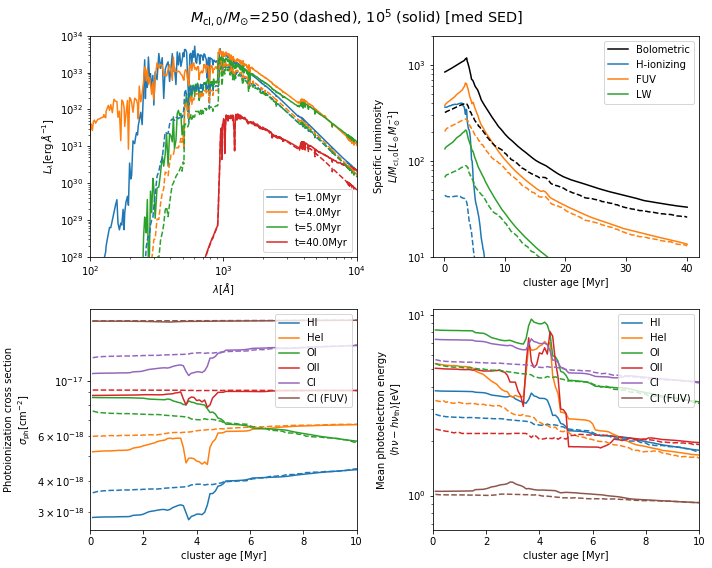

In [175]:
a = IntegrateSED()
kind = 'med'
#kind = 'avg'
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
plt.sca(axes[0])
a.plt_sed(logM=5.0, teval=[1.0, 4.0, 5.0, 40.0],
          kind=kind, add_label=True)
a.plt_sed(logM=2.4, teval=[1.0, 4.0, 5.0, 40.0],
          kind=kind, add_label=False, **dict(ls='--'))

a.integrate_sed(logM=5.0, teval=None, kind='med')
plt.sca(axes[1])
plt.plot(a.teval, a.Lbol/a.Lsun, 'k-', label='Bolometric')
plt.plot(a.teval, a.L['H0']/a.Lsun, label='H-ionizing')
plt.plot(a.teval, a.L['FUV']/a.Lsun, label='FUV')
plt.plot(a.teval, a.L['LW']/a.Lsun, label='LW')
plt.sca(axes[2])
plt.plot(a.teval, a.sigma_ph['HI']['H0'], label='HI')
plt.plot(a.teval, a.sigma_ph['HeI']['H0'], label='HeI')
plt.plot(a.teval, a.sigma_ph['OI']['H0'], label='OI')
plt.plot(a.teval, a.sigma_ph['OII']['H0'], label='OII')
plt.plot(a.teval, a.sigma_ph['CI']['H0'], label='CI')
plt.plot(a.teval, a.sigma_ph['CI']['FUV'], label='CI (FUV)')

plt.sca(axes[3])
plt.plot(a.teval, a.dhnu['HI']['H0'], label='HI')
plt.plot(a.teval, a.dhnu['HeI']['H0'], label='HeI')
plt.plot(a.teval, a.dhnu['OI']['H0'], label='OI')
plt.plot(a.teval, a.dhnu['OII']['H0'], label='OII')
plt.plot(a.teval, a.dhnu['CI']['H0'], label='CI')
plt.plot(a.teval, a.dhnu['CI']['FUV'], label='CI (FUV)')

a.integrate_sed(logM=2.4, teval=None, kind='med')
plt.sca(axes[1])
plt.plot(a.teval, a.Lbol/a.Lsun, 'k--')
plt.plot(a.teval, a.L['H0']/a.Lsun, 'C0--')
plt.plot(a.teval, a.L['FUV']/a.Lsun, 'C1--')
plt.plot(a.teval, a.L['LW']/a.Lsun, 'C2--')
plt.sca(axes[2])
plt.plot(a.teval, a.sigma_ph['HI']['H0'], 'C0--')
plt.plot(a.teval, a.sigma_ph['HeI']['H0'], 'C1--')
plt.plot(a.teval, a.sigma_ph['OI']['H0'], 'C2--')
plt.plot(a.teval, a.sigma_ph['OII']['H0'], 'C3--')
plt.plot(a.teval, a.sigma_ph['CI']['H0'], 'C4--')
plt.plot(a.teval, a.sigma_ph['CI']['FUV'], 'C5--')

plt.sca(axes[3])
plt.plot(a.teval, a.dhnu['HI']['H0'], 'C0--')
plt.plot(a.teval, a.dhnu['HeI']['H0'], 'C1--')
plt.plot(a.teval, a.dhnu['OI']['H0'], 'C2--')
plt.plot(a.teval, a.dhnu['OII']['H0'], 'C3--')
plt.plot(a.teval, a.dhnu['CI']['H0'], 'C4--')
plt.plot(a.teval, a.dhnu['CI']['FUV'], 'C5--')

plt.sca(axes[1])
plt.xlabel('cluster age [Myr]')
plt.ylabel('Specific luminosity\n' + \
           r'$L/M_{\rm cl,0} [L_{\odot}\,M_{\odot}^{-1}]$')
plt.yscale('log')
plt.ylim(1e1, 2e3)
plt.legend(loc=0)

plt.sca(axes[2])
plt.xlabel('cluster age [Myr]')
plt.ylabel('Photoionization cross section\n' + \
           r'$\sigma_{\rm ph} [{\rm cm}^{-2}]$')
plt.yscale('log')
plt.xlim(0, 10)
plt.legend(loc=1)

plt.sca(axes[3])
plt.xlabel('cluster age [Myr]')
plt.ylabel('Mean photoelectron energy\n' + \
           r'$\langle h\nu - h\nu_{\rm th}\rangle [{\rm eV}]$')
plt.yscale('log')
plt.xlim(0, 10)
plt.legend(loc=1)

plt.tight_layout()
plt.suptitle(r'$M_{\rm cl,0}/M_{\odot}$=$250$ (dashed), $10^5$ (solid)' + \
             ' [{0:s} SED]'.format(kind), fontsize='x-large', ha='center')
plt.subplots_adjust(top=0.93)